## Multiplication

A quick and easy example to start off with is to build a toy model which takes in two
numbers, and outputs the result. Although the model doesn't accomplish anything
significant the same techniques can be used to model and train much larger and complex
networks.

`Numpy` is seeded to allow deterministic results, this seeding has no relevance to the
architecture or the training of the network

In [1]:
%matplotlib inline
import nengo
import tensorflow as tf
import nengo_dl
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

### Architecture

We connect two input nodes (`i_1`, `i_2`), both of which generate random numbers, to
ensemble `a`. Then `a` is connected to a second ensemble `b`, which we probe for the
output.

In [2]:
with nengo.Network() as net:

    net.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear()
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Uniform(-1, 1)
    net.config[nengo.Connection].synapse = None

    i_1 = nengo.Node(output=lambda t: np.random.random())
    i_2 = nengo.Node(output=lambda t: np.random.random())

    a = nengo.Ensemble(100, 2)
    b = nengo.Ensemble(100, 1)
    nengo.Connection(i_1, a[0])
    nengo.Connection(i_2, a[1])
    nengo.Connection(a, b, function=lambda x: [0])

    i_1_probe = nengo.Probe(i_1)
    i_2_probe = nengo.Probe(i_2)
    output_probe = nengo.Probe(b)

Before we train the network the output is approximately zero, since that is the function
we specified on the connection from `a` to `b`. However we don't want that output, so we
need to train the network to multiply the inputs.

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               

2022-01-21 11:53:06.875694: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.



Simulation finished in 0:00:01                                                 


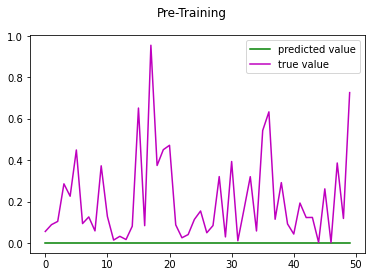

In [3]:
n_steps = 50
minibatch_size = 256
# Showing the output of the model pre training
with nengo_dl.Simulator(net) as sim:
    sim.run_steps(n_steps)
    true_value = np.multiply(sim.data[i_1_probe], sim.data[i_2_probe])
    fig = plt.figure()
    fig.suptitle("Pre-Training")
    plt.plot(sim.data[output_probe], "g", label="predicted value")
    plt.plot(true_value, "m", label="true value")
    plt.legend()

To train the network we generate training feeds which consist of two batches of random
numbers (the inputs) and then the result of those batches multiplied together (the
outputs). Additionally we generate some test data to easily track the progress of the
network throughout training.

In [4]:
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # This feed is used as the "test" data
    # It's run through the network after every iteration
    # to allow easy visulization of how the output is changing
    test_inputs = {
        i_1: np.random.uniform(0, 1, size=(minibatch_size, 1, 1)),
        i_2: np.random.uniform(0, 1, size=(minibatch_size, 1, 1)),
    }
    test_targets = {output_probe: np.multiply(test_inputs[i_1], test_inputs[i_2])}

    # running through 10 rounds of training/testing
    outputs = []
    sim.compile(loss="mse", optimizer=tf.compat.v1.train.MomentumOptimizer(5e-2, 0.9))
    for i in range(10):
        # check performance on test set
        sim.step(data=test_inputs)
        print(f"LOSS: {sim.evaluate(test_inputs, test_targets)}")
        outputs.append(sim.data[output_probe].flatten())

        # run training
        input_feed = {
            i_1: np.random.uniform(0, 1, size=(minibatch_size * 5, 1, 1)),
            i_2: np.random.uniform(0, 1, size=(minibatch_size * 5, 1, 1)),
        }
        output_feed = {output_probe: np.multiply(input_feed[i_1], input_feed[i_2])}
        sim.fit(input_feed, output_feed, epochs=12)
        sim.soft_reset(include_probes=True)

    # check final performance on test set
    sim.step(data=test_inputs)
    print(f"LOSS: {sim.evaluate(test_inputs, test_targets)}")
    outputs.append(sim.data[output_probe].flatten())

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
1/1 [==============================] - 1s 577ms/step - loss: 0.1043 - probe_loss: 0.0000e+00 - probe_1_loss: 0.0000e+00 - probe_2_loss: 0.1043
LOSS: {'loss': 0.1042896956205368, 'probe_loss': 0.0, 'probe_1_loss': 0.0, 'probe_2_loss': 0.1042896956205368}
Epoch 1/12
5/5 [==============================] - 1s 6ms/step - loss: 0.2337 - probe_loss: 0.0000e+00 - probe_1_loss: 0.0000e+00 - probe_2_loss: 0.2337
Epoch 2/12
5/5 [==============================] - 0s 5ms/step - loss: 0.3275 - probe_loss: 0.0000e+00 - probe_1_loss: 0.0000e+00 - probe_2_loss: 0.3275
Epoch 3/12
5/5 [==============================] - 0s 6ms/step - loss: 0.1308 - probe_loss: 0.0000e+00 - probe_1_loss: 0.0000e+00 - probe_2_loss: 0.1308
Epoch 4/12
5/5 [==============================] - 

5/5 [==============================] - 0s 4ms/step - loss: 8.2921e-05 - probe_loss: 0.0000e+00 - probe_1_loss: 0.0000e+00 - probe_2_loss: 8.2921e-05
Epoch 9/12
5/5 [==============================] - 0s 4ms/step - loss: 8.3131e-05 - probe_loss: 0.0000e+00 - probe_1_loss: 0.0000e+00 - probe_2_loss: 8.3131e-05
Epoch 10/12
5/5 [==============================] - 0s 4ms/step - loss: 8.4504e-05 - probe_loss: 0.0000e+00 - probe_1_loss: 0.0000e+00 - probe_2_loss: 8.4504e-05
Epoch 11/12
5/5 [==============================] - 0s 6ms/step - loss: 8.3002e-05 - probe_loss: 0.0000e+00 - probe_1_loss: 0.0000e+00 - probe_2_loss: 8.3002e-05
Epoch 12/12
1/1 [==============================] - 0s 18ms/step - loss: 7.4353e-05 - probe_loss: 0.0000e+00 - probe_1_loss: 0.0000e+00 - probe_2_loss: 7.4353e-05
LOSS: {'loss': 7.435342558892444e-05, 'probe_loss': 0.0, 'probe_1_loss': 0.0, 'probe_2_loss': 7.435342558892444e-05}
Epoch 1/12
5/5 [==============================] - 0s 4ms/step - loss: 8.6869e-05 - probe_l

5/5 [==============================] - 0s 4ms/step - loss: 6.2528e-05 - probe_loss: 0.0000e+00 - probe_1_loss: 0.0000e+00 - probe_2_loss: 6.2528e-05
Epoch 5/12
5/5 [==============================] - 0s 3ms/step - loss: 6.0573e-05 - probe_loss: 0.0000e+00 - probe_1_loss: 0.0000e+00 - probe_2_loss: 6.0573e-05
Epoch 6/12
5/5 [==============================] - 0s 5ms/step - loss: 6.6364e-05 - probe_loss: 0.0000e+00 - probe_1_loss: 0.0000e+00 - probe_2_loss: 6.6364e-05
Epoch 7/12
5/5 [==============================] - 0s 6ms/step - loss: 6.3155e-05 - probe_loss: 0.0000e+00 - probe_1_loss: 0.0000e+00 - probe_2_loss: 6.3155e-05
Epoch 8/12
5/5 [==============================] - 0s 5ms/step - loss: 6.6353e-05 - probe_loss: 0.0000e+00 - probe_1_loss: 0.0000e+00 - probe_2_loss: 6.6353e-05
Epoch 9/12
5/5 [==============================] - 0s 6ms/step - loss: 6.7410e-05 - probe_loss: 0.0000e+00 - probe_1_loss: 0.0000e+00 - probe_2_loss: 6.7410e-05
Epoch 10/12
5/5 [==============================] - 

We visualize the results by plotting the pre-trained, trained and ideal outputs next to
each other

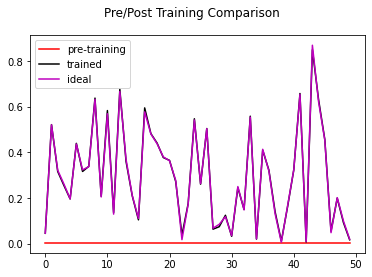

In [5]:
fig = plt.figure()
fig.suptitle("Pre/Post Training Comparison")
plt.plot(outputs[0][:50], "r", label="pre-training")
plt.plot(outputs[10][:50], "k", label="trained")
plt.plot(test_targets[output_probe].flatten()[:50], "m", label="ideal")
plt.legend()